In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import keras
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix   

2023-05-19 07:46:42.394465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-19 07:46:42.394515: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Import the data

In [2]:
import pandas as pd
from sklearn.utils import shuffle

# Read the CSV file into a pandas DataFrame
data = pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")

In [3]:
def get_data_with_ratio(ratio):
    # Shuffle the data
    shuffled_data = shuffle(data, random_state=42)

    # Get unique classes from the "Peruntukan" column
    classes = shuffled_data['Peruntukan'].unique()

    # Initialize empty dataframes for train and test data
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # Iterate over each class
    for cls in classes:
        cls_data = shuffled_data[shuffled_data['Peruntukan'] == cls]

        # Split the class data into train and test
        cls_train, cls_test = train_test_split(cls_data, test_size=0.5, random_state=42)

        # Append the train and test data to the respective dataframes
        train_data = train_data.append(cls_train)
        test_data = test_data.append(cls_test)
        
        training = train_data
        test = test_data

        training = training[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]
        test = test[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]


    
    return training, test


# Data visualisasi

# Change categorical to number 

In [4]:
def change_categorical_to_number(data):
    
    data = data
    
 
    ####
    ####

    condition = [  data.Visibilitas == "Strategis",
                 data.Visibilitas == "Sedang",
                  data.Visibilitas == "Kurang",
    ]

    value = [3,2,1]

    data.Visibilitas = np.select(condition,value)
    #####
    #####

    condition = [  data.Bangunan == "Bagus",
                 data.Bangunan == "Sedang",

    ]

    value = [2,1]

    data.Bangunan = np.select(condition,value,0)


    condition = [ 
                data.Peruntukan == "Pasar",
                 data.Peruntukan == "Kantor",
                 data.Peruntukan == "Ruko",
                 data.Peruntukan == "Taman",
                 data.Peruntukan == "Perumahan",
                 data.Peruntukan == "Sawah",

    ]

    value = [5,4,3,2,1,0]

    data.Peruntukan = np.select(condition,value,0)
    
    return data

# Dataframe to Dataset

In [5]:
def df_to_dataset(dataframe, shuffle=False, batch_size=4):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Peruntukan')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

# Feature Normalizer

In [6]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [7]:
def encoded_features(train_ds):
    all_inputs = []
    encoded_features = []

    # Numerical features.
    for header in ["Jarak pusat kota2","Visibilitas","Bangunan","Luas"]:
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, train_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)
    return encoded_features, all_inputs

In [8]:
checkpoint_callback = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

# Model build

In [9]:
def model(encoded_features,all_inputs):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(6)(x)

    model = tf.keras.Model(all_inputs, output)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics="accuracy",
                 )
    
    return model

# History build

In [10]:
def history(model,callbacks,train_ds,val_ds):
    

    history = model.fit(train_ds, epochs=150, validation_data=val_ds, callbacks=callbacks)

    # Get the training and validation metrics from the history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    max_test_accuracy_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = history.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(history.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)
    
    return history


# Evaluation the Model

In [11]:
def run_model(ratio,callbacks):
    
    #split data
    training, test_2 = get_data_with_ratio(ratio)
    
    #change data to number
    training = change_categorical_to_number(training)
    test = change_categorical_to_number(test_2)
    
    #df to ds
    
    train_ds = df_to_dataset(training)
    val_ds = df_to_dataset(test)
    
    #encoded features
    
    encoded,inputs = encoded_features(train_ds)

    
    #set the model
    model_engine = model(encoded,inputs)
    
    #run and evaluate the model
    model_engine2 = history(model_engine,callbacks,train_ds,val_ds)
    
    #evaluate confusion matrix
    confussion_matrix(model_engine2,val_ds,test_2)

In [12]:
def confussion_matrix(best_model, val_ds,test_data):
    from sklearn.metrics import confusion_matrix   
    model =  best_model
    
    y_pred = model.model.predict(val_ds)

    # Ubah output prediksi menjadi label kelas
    label_kelas = [0, 1, 2, 3, 4, 5]
    y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

    #test label
    test_labels = test_data.Peruntukan

    # Calculate the confusion matrix
    cm = confusion_matrix(test_labels, y_pred_label)
    
    max_test_accuracy_index = model.history['val_accuracy'].index(max(model.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = model.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(model.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)


    print('Confusion matrix:')
    print(cm)
    
    confusion_matrix = cm
    
    true_positives = np.diagonal(confusion_matrix)

    # Step 3: Calculate the accuracy percentage for each class
    class_data_totals = np.sum(confusion_matrix, axis=0)
    class_accuracies = true_positives / class_data_totals * 100

    # Step 4: Calculate the overall accuracy percentage
    total_instances = np.sum(confusion_matrix)
    overall_accuracy = np.sum(true_positives) / total_instances * 100

    
    for label, accuracy in zip(label_kelas, class_accuracies):
        print("Accuracy for", label, ":", accuracy)
    
    
    
    true_positives = np.diagonal(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

    # Step 3: Calculate precision, recall, and F1 score for each label
    accuracy = true_positives / np.sum(confusion_matrix, axis=1)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Step 4: Calculate the total accuracy
    total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100
    
    mean_accuracy = np.mean(accuracy)
    total_precision = np.mean(precision)
    total_recall = np.mean(recall)
    total_f1 = np.mean(f1_score)

    class_data_totals = np.sum(confusion_matrix, axis=1)


    # Print the results
 
        # Print the results
   
    print("mean accuracy:", mean_accuracy)
    print("Total Precision:", total_precision)
    print("Total Recall:", total_recall)
    print("Total F1 Score:", total_f1)
    print("Accuracy for each label:", class_accuracies)
    print("Precision for each label:", precision)
    print("Recall for each label:", recall)
    print("F1 Score for each label:", f1_score)
   
    
    weights = class_data_totals / np.sum(class_data_totals)  # Calculate weights based on class distribution
    weighted_precision = np.sum(precision * weights)
    weighted_recall = np.sum(recall * weights)
    weighted_f1_score = np.sum(f1_score * weights)

    # Print the results
    
    print("")
    print("")
    print("Total Accuracy:", total_accuracy)
    print("Weighted Precision:", weighted_precision)
    print("Weighted Recall:", weighted_recall)
    print("Weighted F1 Score:", weighted_f1_score)

# Model Evaluation

In [13]:
callback_1 = ModelCheckpoint("50.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_1 = 0.5

callback_2= ModelCheckpoint("40.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_2 = 0.4

callback_3= ModelCheckpoint("30.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_3 = 0.3

callback_4= ModelCheckpoint("20.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_4 = 0.2

callback_5= ModelCheckpoint("10.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_5 = 0.1

/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_470098/3228669218.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_470098/3228669218.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Epoch 1/150
13/13 [==============================] - 1s 38ms/step - loss: 2.1529 - accuracy: 0.2041 - val_loss: 1.8804 - val_accuracy: 0.2778
Epoch 2/150
13/13 [==============================] - 0s 10ms/step - loss: 1.9319 - accuracy: 0.1633 - val_loss: 1.8138 - val_accuracy: 0.3519
Epoch 3/150
13/13 [==============================] - 0s 10ms/step - loss: 2.0299 - accuracy: 0.3469 - val_loss: 1.7528 - val_accuracy: 0.4074
Epoch 4/150
13/13 [==============================] - 0s 10ms/step - loss: 1.9944 - accuracy: 0.2449 - val_loss: 1.6988 - val_accuracy: 0.4444
Epoch 5/150
13/13 [==============================] - 0s 10ms/step - loss: 1.9939 - accuracy: 0.2245 - val_loss: 1.6442 - val_accuracy: 0.4815
Epoch 6/150
13/13 [==============================] - 0s 7ms/step - loss: 1.6979 - accuracy: 0.3061 - val_loss: 1.5969 - val_accuracy: 0.4815
Epoch 7/150
13/13 [==============================] - 0s 8ms/step - loss: 1.6745 - accuracy: 0.3878 - val_loss: 1.5534 - val_accuracy: 0.4815
Epoch 8/

Epoch 59/150
13/13 [==============================] - 0s 6ms/step - loss: 0.8799 - accuracy: 0.6735 - val_loss: 0.7723 - val_accuracy: 0.7222
Epoch 60/150
13/13 [==============================] - 0s 6ms/step - loss: 0.6646 - accuracy: 0.8571 - val_loss: 0.7652 - val_accuracy: 0.7222
Epoch 61/150
13/13 [==============================] - 0s 6ms/step - loss: 0.8442 - accuracy: 0.6735 - val_loss: 0.7591 - val_accuracy: 0.7222
Epoch 62/150
13/13 [==============================] - 0s 7ms/step - loss: 0.8271 - accuracy: 0.7551 - val_loss: 0.7532 - val_accuracy: 0.7222
Epoch 63/150
13/13 [==============================] - 0s 6ms/step - loss: 0.8986 - accuracy: 0.6939 - val_loss: 0.7469 - val_accuracy: 0.7222
Epoch 64/150
13/13 [==============================] - 0s 6ms/step - loss: 0.7404 - accuracy: 0.7755 - val_loss: 0.7406 - val_accuracy: 0.7222
Epoch 65/150
13/13 [==============================] - 0s 6ms/step - loss: 0.7721 - accuracy: 0.8163 - val_loss: 0.7344 - val_accuracy: 0.7222
Epoch 

13/13 [==============================] - 0s 9ms/step - loss: 0.5223 - accuracy: 0.8571 - val_loss: 0.4992 - val_accuracy: 0.8704
Epoch 117/150
13/13 [==============================] - 0s 6ms/step - loss: 0.5209 - accuracy: 0.8571 - val_loss: 0.4942 - val_accuracy: 0.8704
Epoch 118/150
13/13 [==============================] - 0s 6ms/step - loss: 0.6036 - accuracy: 0.7959 - val_loss: 0.4900 - val_accuracy: 0.8704
Epoch 119/150
13/13 [==============================] - 0s 6ms/step - loss: 0.5538 - accuracy: 0.7959 - val_loss: 0.4861 - val_accuracy: 0.8704
Epoch 120/150
13/13 [==============================] - 0s 6ms/step - loss: 0.5732 - accuracy: 0.7347 - val_loss: 0.4824 - val_accuracy: 0.8704
Epoch 121/150
13/13 [==============================] - 0s 7ms/step - loss: 0.6276 - accuracy: 0.7755 - val_loss: 0.4800 - val_accuracy: 0.8704
Epoch 122/150
13/13 [==============================] - 0s 7ms/step - loss: 0.5613 - accuracy: 0.8367 - val_loss: 0.4779 - val_accuracy: 0.8704
Epoch 123/150

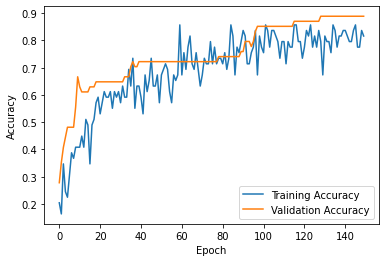

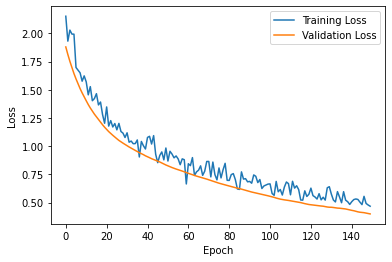

Best validation accuracy: 0.8888888955116272
Training accuracy at the best test accuracy: 0.795918345451355
Best validation accuracy: 0.8888888955116272
Training accuracy at the best test accuracy: 0.795918345451355
Confusion matrix:
[[12  0  0  0  0  0]
 [ 0  4  0  0  0  0]
 [ 1  0  2  0  0  0]
 [ 0  0  0 20  0  1]
 [ 0  0  0  0  6  0]
 [ 0  0  0  4  0  4]]
Accuracy for 0 : 92.3076923076923
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 83.33333333333334
Accuracy for 4 : 100.0
Accuracy for 5 : 80.0
mean accuracy: 0.8531746031746031
Total Precision: 0.9260683760683762
Total Recall: 0.8531746031746031
Total F1 Score: 0.8773789173789174
Accuracy for each label: [ 92.30769231 100.         100.          83.33333333 100.
  80.        ]
Precision for each label: [0.92307692 1.         1.         0.83333333 1.         0.8       ]
Recall for each label: [1.         1.         0.66666667 0.95238095 1.         0.5       ]
F1 Score for each label: [0.96       1.         0.8       

In [14]:
run_model(ratio_1, callback_1)

/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_470098/3228669218.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_470098/3228669218.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Epoch 1/150
13/13 [==============================] - 1s 28ms/step - loss: 1.9386 - accuracy: 0.0408 - val_loss: 1.8995 - val_accuracy: 0.1481
Epoch 2/150
13/13 [==============================] - 0s 7ms/step - loss: 1.9861 - accuracy: 0.1429 - val_loss: 1.8373 - val_accuracy: 0.1481
Epoch 3/150
13/13 [==============================] - 0s 7ms/step - loss: 1.8320 - accuracy: 0.1633 - val_loss: 1.7813 - val_accuracy: 0.1481
Epoch 4/150
13/13 [==============================] - 0s 9ms/step - loss: 1.8148 - accuracy: 0.1429 - val_loss: 1.7319 - val_accuracy: 0.2407
Epoch 5/150
13/13 [==============================] - 0s 9ms/step - loss: 1.6461 - accuracy: 0.1837 - val_loss: 1.6875 - val_accuracy: 0.4259
Epoch 6/150
13/13 [==============================] - 0s 10ms/step - loss: 1.7648 - accuracy: 0.2653 - val_loss: 1.6449 - val_accuracy: 0.4444
Epoch 7/150
13/13 [==============================] - 0s 6ms/step - loss: 1.6153 - accuracy: 0.3878 - val_loss: 1.6030 - val_accuracy: 0.4444
Epoch 8/150

Epoch 59/150
13/13 [==============================] - 0s 6ms/step - loss: 0.7471 - accuracy: 0.7347 - val_loss: 0.7244 - val_accuracy: 0.7222
Epoch 60/150
13/13 [==============================] - 0s 7ms/step - loss: 0.7200 - accuracy: 0.7959 - val_loss: 0.7165 - val_accuracy: 0.7222
Epoch 61/150
13/13 [==============================] - 0s 9ms/step - loss: 0.7673 - accuracy: 0.7551 - val_loss: 0.7090 - val_accuracy: 0.7407
Epoch 62/150
13/13 [==============================] - 0s 10ms/step - loss: 0.7198 - accuracy: 0.7347 - val_loss: 0.7017 - val_accuracy: 0.7593
Epoch 63/150
13/13 [==============================] - 0s 6ms/step - loss: 0.8293 - accuracy: 0.6735 - val_loss: 0.6944 - val_accuracy: 0.7593
Epoch 64/150
13/13 [==============================] - 0s 6ms/step - loss: 0.7315 - accuracy: 0.7347 - val_loss: 0.6864 - val_accuracy: 0.7593
Epoch 65/150
13/13 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.7551 - val_loss: 0.6788 - val_accuracy: 0.7593
Epoch

13/13 [==============================] - 0s 9ms/step - loss: 0.5213 - accuracy: 0.8980 - val_loss: 0.4540 - val_accuracy: 0.8889
Epoch 117/150
13/13 [==============================] - 0s 6ms/step - loss: 0.4680 - accuracy: 0.8980 - val_loss: 0.4514 - val_accuracy: 0.8889
Epoch 118/150
13/13 [==============================] - 0s 6ms/step - loss: 0.4954 - accuracy: 0.8571 - val_loss: 0.4494 - val_accuracy: 0.8889
Epoch 119/150
13/13 [==============================] - 0s 6ms/step - loss: 0.5492 - accuracy: 0.7755 - val_loss: 0.4471 - val_accuracy: 0.8889
Epoch 120/150
13/13 [==============================] - 0s 6ms/step - loss: 0.5526 - accuracy: 0.7959 - val_loss: 0.4446 - val_accuracy: 0.8889
Epoch 121/150
13/13 [==============================] - 0s 7ms/step - loss: 0.5830 - accuracy: 0.7755 - val_loss: 0.4438 - val_accuracy: 0.8889
Epoch 122/150
13/13 [==============================] - 0s 7ms/step - loss: 0.4889 - accuracy: 0.8571 - val_loss: 0.4416 - val_accuracy: 0.8889
Epoch 123/150

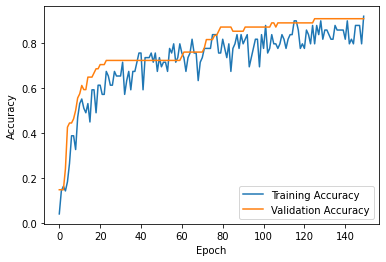

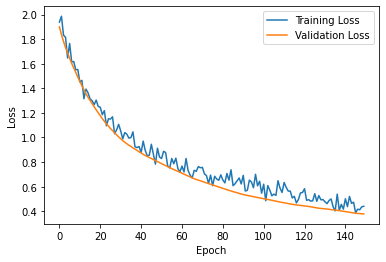

Best validation accuracy: 0.9074074029922485
Training accuracy at the best test accuracy: 0.795918345451355
Best validation accuracy: 0.9074074029922485
Training accuracy at the best test accuracy: 0.795918345451355
Confusion matrix:
[[12  0  0  0  0  0]
 [ 0  4  0  0  0  0]
 [ 0  0  3  0  0  0]
 [ 0  0  0 20  0  1]
 [ 0  0  0  0  6  0]
 [ 0  0  0  4  0  4]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 83.33333333333334
Accuracy for 4 : 100.0
Accuracy for 5 : 80.0
mean accuracy: 0.9087301587301587
Total Precision: 0.938888888888889
Total Recall: 0.9087301587301587
Total F1 Score: 0.9173789173789174
Accuracy for each label: [100.         100.         100.          83.33333333 100.
  80.        ]
Precision for each label: [1.         1.         1.         0.83333333 1.         0.8       ]
Recall for each label: [1.         1.         1.         0.95238095 1.         0.5       ]
F1 Score for each label: [1.         1.         1.         0.88888889 

In [15]:
run_model(ratio_2, callback_2)

/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_470098/3228669218.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_470098/3228669218.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Epoch 1/150
13/13 [==============================] - 1s 21ms/step - loss: 2.0347 - accuracy: 0.1224 - val_loss: 1.8526 - val_accuracy: 0.2037
Epoch 2/150
13/13 [==============================] - 0s 5ms/step - loss: 1.8634 - accuracy: 0.2245 - val_loss: 1.7941 - val_accuracy: 0.2037
Epoch 3/150
13/13 [==============================] - 0s 5ms/step - loss: 1.8688 - accuracy: 0.1837 - val_loss: 1.7445 - val_accuracy: 0.2037
Epoch 4/150
13/13 [==============================] - 0s 5ms/step - loss: 1.7238 - accuracy: 0.2857 - val_loss: 1.6974 - val_accuracy: 0.2037
Epoch 5/150
13/13 [==============================] - 0s 9ms/step - loss: 1.7366 - accuracy: 0.2857 - val_loss: 1.6533 - val_accuracy: 0.2222
Epoch 6/150
13/13 [==============================] - 0s 8ms/step - loss: 1.6121 - accuracy: 0.3265 - val_loss: 1.6094 - val_accuracy: 0.3519
Epoch 7/150
13/13 [==============================] - 0s 8ms/step - loss: 1.6512 - accuracy: 0.2857 - val_loss: 1.5679 - val_accuracy: 0.3704
Epoch 8/150


Epoch 59/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8368 - accuracy: 0.7143 - val_loss: 0.7578 - val_accuracy: 0.7037
Epoch 60/150
13/13 [==============================] - 0s 5ms/step - loss: 0.9690 - accuracy: 0.6122 - val_loss: 0.7492 - val_accuracy: 0.7037
Epoch 61/150
13/13 [==============================] - 0s 6ms/step - loss: 0.8742 - accuracy: 0.6735 - val_loss: 0.7417 - val_accuracy: 0.7037
Epoch 62/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8357 - accuracy: 0.6327 - val_loss: 0.7338 - val_accuracy: 0.7037
Epoch 63/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7856 - accuracy: 0.7347 - val_loss: 0.7268 - val_accuracy: 0.7037
Epoch 64/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8528 - accuracy: 0.6735 - val_loss: 0.7195 - val_accuracy: 0.7037
Epoch 65/150
13/13 [==============================] - 0s 7ms/step - loss: 0.9471 - accuracy: 0.6531 - val_loss: 0.7133 - val_accuracy: 0.7222
Epoch 

13/13 [==============================] - 0s 9ms/step - loss: 0.5046 - accuracy: 0.8571 - val_loss: 0.4494 - val_accuracy: 0.8519
Epoch 117/150
13/13 [==============================] - 0s 5ms/step - loss: 0.4729 - accuracy: 0.8367 - val_loss: 0.4461 - val_accuracy: 0.8519
Epoch 118/150
13/13 [==============================] - 0s 5ms/step - loss: 0.5026 - accuracy: 0.8367 - val_loss: 0.4426 - val_accuracy: 0.8519
Epoch 119/150
13/13 [==============================] - 0s 9ms/step - loss: 0.5473 - accuracy: 0.7959 - val_loss: 0.4395 - val_accuracy: 0.8519
Epoch 120/150
13/13 [==============================] - 0s 15ms/step - loss: 0.4639 - accuracy: 0.8980 - val_loss: 0.4361 - val_accuracy: 0.8704
Epoch 121/150
13/13 [==============================] - 0s 8ms/step - loss: 0.5293 - accuracy: 0.8163 - val_loss: 0.4329 - val_accuracy: 0.8704
Epoch 122/150
13/13 [==============================] - 0s 7ms/step - loss: 0.5429 - accuracy: 0.7959 - val_loss: 0.4298 - val_accuracy: 0.8704
Epoch 123/15

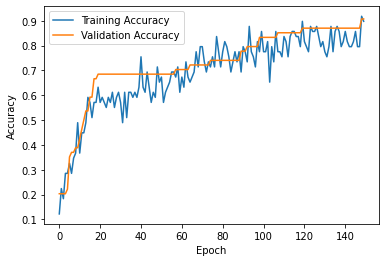

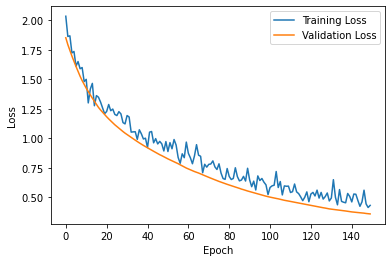

Best validation accuracy: 0.9074074029922485
Training accuracy at the best test accuracy: 0.918367326259613
Best validation accuracy: 0.9074074029922485
Training accuracy at the best test accuracy: 0.918367326259613
Confusion matrix:
[[12  0  0  0  0  0]
 [ 0  4  0  0  0  0]
 [ 0  0  3  0  0  0]
 [ 0  0  0 20  0  1]
 [ 0  0  0  0  6  0]
 [ 0  0  0  4  0  4]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 83.33333333333334
Accuracy for 4 : 100.0
Accuracy for 5 : 80.0
mean accuracy: 0.9087301587301587
Total Precision: 0.938888888888889
Total Recall: 0.9087301587301587
Total F1 Score: 0.9173789173789174
Accuracy for each label: [100.         100.         100.          83.33333333 100.
  80.        ]
Precision for each label: [1.         1.         1.         0.83333333 1.         0.8       ]
Recall for each label: [1.         1.         1.         0.95238095 1.         0.5       ]
F1 Score for each label: [1.         1.         1.         0.88888889 

In [16]:
run_model(ratio_3, callback_3)

/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_470098/3228669218.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_470098/3228669218.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Epoch 1/150
13/13 [==============================] - 1s 21ms/step - loss: 2.0145 - accuracy: 0.1429 - val_loss: 2.1183 - val_accuracy: 0.1481
Epoch 2/150
13/13 [==============================] - 0s 6ms/step - loss: 1.9336 - accuracy: 0.1633 - val_loss: 2.0528 - val_accuracy: 0.1481
Epoch 3/150
13/13 [==============================] - 0s 6ms/step - loss: 1.8623 - accuracy: 0.2653 - val_loss: 1.9919 - val_accuracy: 0.1481
Epoch 4/150
13/13 [==============================] - 0s 8ms/step - loss: 1.8251 - accuracy: 0.2245 - val_loss: 1.9344 - val_accuracy: 0.1667
Epoch 5/150
13/13 [==============================] - 0s 7ms/step - loss: 1.7161 - accuracy: 0.3265 - val_loss: 1.8815 - val_accuracy: 0.2407
Epoch 6/150
13/13 [==============================] - 0s 8ms/step - loss: 1.7933 - accuracy: 0.3061 - val_loss: 1.8291 - val_accuracy: 0.4259
Epoch 7/150
13/13 [==============================] - 0s 5ms/step - loss: 1.6872 - accuracy: 0.3673 - val_loss: 1.7789 - val_accuracy: 0.4259
Epoch 8/150


Epoch 59/150
13/13 [==============================] - 0s 6ms/step - loss: 0.8943 - accuracy: 0.7143 - val_loss: 0.8853 - val_accuracy: 0.7222
Epoch 60/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8454 - accuracy: 0.6939 - val_loss: 0.8759 - val_accuracy: 0.7037
Epoch 61/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8628 - accuracy: 0.7347 - val_loss: 0.8676 - val_accuracy: 0.7037
Epoch 62/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7421 - accuracy: 0.7959 - val_loss: 0.8592 - val_accuracy: 0.7037
Epoch 63/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8798 - accuracy: 0.6531 - val_loss: 0.8529 - val_accuracy: 0.7037
Epoch 64/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7376 - accuracy: 0.7959 - val_loss: 0.8459 - val_accuracy: 0.7037
Epoch 65/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7732 - accuracy: 0.7551 - val_loss: 0.8371 - val_accuracy: 0.7222
Epoch 

13/13 [==============================] - 0s 6ms/step - loss: 0.6230 - accuracy: 0.7959 - val_loss: 0.5852 - val_accuracy: 0.8148
Epoch 117/150
13/13 [==============================] - 0s 5ms/step - loss: 0.5565 - accuracy: 0.7959 - val_loss: 0.5802 - val_accuracy: 0.8148
Epoch 118/150
13/13 [==============================] - 0s 5ms/step - loss: 0.5759 - accuracy: 0.7959 - val_loss: 0.5774 - val_accuracy: 0.8148
Epoch 119/150
13/13 [==============================] - 0s 5ms/step - loss: 0.6390 - accuracy: 0.7959 - val_loss: 0.5756 - val_accuracy: 0.8148
Epoch 120/150
13/13 [==============================] - 0s 5ms/step - loss: 0.6610 - accuracy: 0.7755 - val_loss: 0.5742 - val_accuracy: 0.8148
Epoch 121/150
13/13 [==============================] - 0s 5ms/step - loss: 0.5861 - accuracy: 0.7959 - val_loss: 0.5723 - val_accuracy: 0.8148
Epoch 122/150
13/13 [==============================] - 0s 5ms/step - loss: 0.5764 - accuracy: 0.7959 - val_loss: 0.5687 - val_accuracy: 0.8148
Epoch 123/150

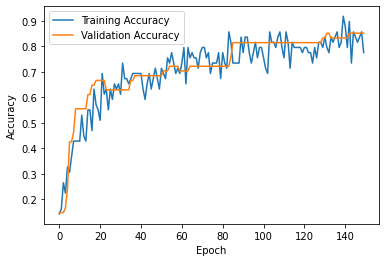

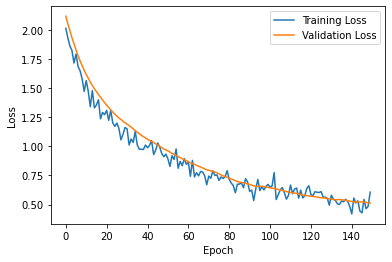

Best validation accuracy: 0.8518518805503845
Training accuracy at the best test accuracy: 0.795918345451355
Best validation accuracy: 0.8518518805503845
Training accuracy at the best test accuracy: 0.795918345451355
Confusion matrix:
[[12  0  0  0  0  0]
 [ 2  2  0  0  0  0]
 [ 0  0  2  1  0  0]
 [ 0  0  0 20  0  1]
 [ 0  0  0  0  6  0]
 [ 0  0  0  4  0  4]]
Accuracy for 0 : 85.71428571428571
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 80.0
Accuracy for 4 : 100.0
Accuracy for 5 : 80.0
mean accuracy: 0.7698412698412698
Total Precision: 0.9095238095238095
Total Recall: 0.7698412698412698
Total F1 Score: 0.8124489037532516
Accuracy for each label: [ 85.71428571 100.         100.          80.         100.
  80.        ]
Precision for each label: [0.85714286 1.         1.         0.8        1.         0.8       ]
Recall for each label: [1.         0.5        0.66666667 0.95238095 1.         0.5       ]
F1 Score for each label: [0.92307692 0.66666667 0.8        0.86956522 

In [17]:
run_model(ratio_4, callback_4)

/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_470098/3228669218.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_470098/3228669218.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_470098/3228669218.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Epoch 1/150
13/13 [==============================] - 1s 21ms/step - loss: 1.8580 - accuracy: 0.1429 - val_loss: 2.0889 - val_accuracy: 0.1852
Epoch 2/150
13/13 [==============================] - 0s 8ms/step - loss: 1.7957 - accuracy: 0.2449 - val_loss: 2.0343 - val_accuracy: 0.3704
Epoch 3/150
13/13 [==============================] - 0s 6ms/step - loss: 1.7526 - accuracy: 0.2449 - val_loss: 1.9843 - val_accuracy: 0.3704
Epoch 4/150
13/13 [==============================] - 0s 7ms/step - loss: 1.7194 - accuracy: 0.3265 - val_loss: 1.9379 - val_accuracy: 0.4074
Epoch 5/150
13/13 [==============================] - 0s 8ms/step - loss: 1.6340 - accuracy: 0.3878 - val_loss: 1.8930 - val_accuracy: 0.4630
Epoch 6/150
13/13 [==============================] - 0s 6ms/step - loss: 1.6834 - accuracy: 0.3673 - val_loss: 1.8512 - val_accuracy: 0.4630
Epoch 7/150
13/13 [==============================] - 0s 6ms/step - loss: 1.6185 - accuracy: 0.4694 - val_loss: 1.8086 - val_accuracy: 0.4630
Epoch 8/150


Epoch 59/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7054 - accuracy: 0.7959 - val_loss: 0.7718 - val_accuracy: 0.7037
Epoch 60/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7606 - accuracy: 0.7551 - val_loss: 0.7632 - val_accuracy: 0.7037
Epoch 61/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8370 - accuracy: 0.6531 - val_loss: 0.7526 - val_accuracy: 0.7037
Epoch 62/150
13/13 [==============================] - 0s 7ms/step - loss: 0.7670 - accuracy: 0.7755 - val_loss: 0.7463 - val_accuracy: 0.7222
Epoch 63/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7275 - accuracy: 0.7347 - val_loss: 0.7401 - val_accuracy: 0.7037
Epoch 64/150
13/13 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.7959 - val_loss: 0.7327 - val_accuracy: 0.7037
Epoch 65/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7171 - accuracy: 0.7959 - val_loss: 0.7247 - val_accuracy: 0.7037
Epoch 

13/13 [==============================] - 0s 5ms/step - loss: 0.5446 - accuracy: 0.8367 - val_loss: 0.4710 - val_accuracy: 0.8704
Epoch 117/150
13/13 [==============================] - 0s 6ms/step - loss: 0.6284 - accuracy: 0.7551 - val_loss: 0.4711 - val_accuracy: 0.8704
Epoch 118/150
13/13 [==============================] - 0s 5ms/step - loss: 0.4541 - accuracy: 0.8776 - val_loss: 0.4690 - val_accuracy: 0.8704
Epoch 119/150
13/13 [==============================] - 0s 5ms/step - loss: 0.4790 - accuracy: 0.8367 - val_loss: 0.4659 - val_accuracy: 0.8704
Epoch 120/150
13/13 [==============================] - 0s 5ms/step - loss: 0.5341 - accuracy: 0.8163 - val_loss: 0.4620 - val_accuracy: 0.8704
Epoch 121/150
13/13 [==============================] - 0s 9ms/step - loss: 0.4447 - accuracy: 0.8776 - val_loss: 0.4588 - val_accuracy: 0.8889
Epoch 122/150
13/13 [==============================] - 0s 6ms/step - loss: 0.5081 - accuracy: 0.8163 - val_loss: 0.4559 - val_accuracy: 0.8889
Epoch 123/150

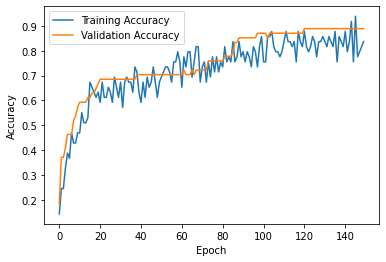

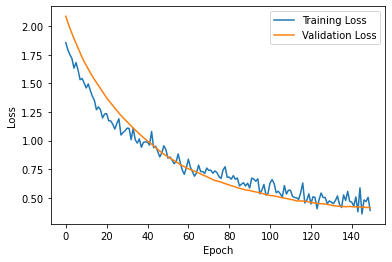

Best validation accuracy: 0.8888888955116272
Training accuracy at the best test accuracy: 0.8775510191917419
Best validation accuracy: 0.8888888955116272
Training accuracy at the best test accuracy: 0.8775510191917419
Confusion matrix:
[[12  0  0  0  0  0]
 [ 0  3  0  0  1  0]
 [ 0  0  3  0  0  0]
 [ 0  0  0 20  0  1]
 [ 0  0  0  0  6  0]
 [ 0  0  0  4  0  4]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 83.33333333333334
Accuracy for 4 : 85.71428571428571
Accuracy for 5 : 80.0
mean accuracy: 0.8670634920634921
Total Precision: 0.915079365079365
Total Recall: 0.8670634920634921
Total F1 Score: 0.8807488807488809
Accuracy for each label: [100.         100.         100.          83.33333333  85.71428571
  80.        ]
Precision for each label: [1.         1.         1.         0.83333333 0.85714286 0.8       ]
Recall for each label: [1.         0.75       1.         0.95238095 1.         0.5       ]
F1 Score for each label: [1.         0.85714286 

In [18]:
run_model(ratio_5, callback_5)

# Confusion Matriks

In [19]:
confusion_matrix = cm

true_positives = np.diagonal(confusion_matrix)

# Step 3: Calculate the accuracy percentage for each class
class_totals = np.sum(confusion_matrix, axis=1)
class_accuracies = true_positives / class_totals * 100

# Step 4: Calculate the overall accuracy percentage
total_instances = np.sum(confusion_matrix)
overall_accuracy = np.sum(true_positives) / total_instances * 100

# Step 5: Calculate the total data instances for each class
class_data_totals = np.sum(confusion_matrix, axis=0)

# Print the results
print("True Positives for each class:", true_positives)
print("Total Data Instances for each class:", class_data_totals)
print("Overall Accuracy Percentage:", overall_accuracy)

NameError: name 'cm' is not defined

In [ ]:
true_positives = np.diagonal(confusion_matrix)

# Step 3: Calculate the accuracy percentage for each class
class_data_totals = np.sum(confusion_matrix, axis=0)
class_accuracies = true_positives / class_data_totals * 100

# Step 4: Calculate the overall accuracy percentage
total_instances = np.sum(confusion_matrix)
overall_accuracy = np.sum(true_positives) / total_instances * 100

# Print the results
print("Accuracy for each label:", class_accuracies)
print("True Positives for each class:", true_positives)
print("Total Data Instances for each class:", class_data_totals)
print("Overall Accuracy Percentage:", overall_accuracy)

In [ ]:
for label, accuracy in zip(label_kelas, class_accuracies):
    print("Accuracy for", label, ":", accuracy)
    

In [ ]:
true_positives = np.diagonal(confusion_matrix)
false_positives = np.sum(confusion_matrix, axis=0) - true_positives
false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

# Step 3: Calculate precision, recall, and F1 score for each label
accuracy = true_positives / np.sum(confusion_matrix, axis=1)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Step 4: Calculate the total accuracy
total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100

# Print the results
print("Accuracy for each label:", class_accuracies)
print("Precision for each label:", precision)
print("Recall for each label:", recall)
print("F1 Score for each label:", f1_score)
print("Total Accuracy:", total_accuracy)

In [ ]:
true_positives = np.diagonal(confusion_matrix)
false_positives = np.sum(confusion_matrix, axis=0) - true_positives
false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

# Step 3: Calculate precision, recall, and F1 score for each label
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Step 4: Calculate the total accuracy
total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100

# Print the results
print("True Positives for each label:", true_positives)
print("total classes",class_data_totals)
print("tp+fp pembagi precision",true_positives + false_positives )
print("tp+fn pembagi recall",true_positives + false_negatives )
print("f1 p kali r", (precision * recall))

In [ ]:
max_test_accuracy_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

# Get the corresponding training accuracy
training_accuracy = history.history['accuracy'][max_test_accuracy_index]

print('Best validation accuracy:', max(history.history['val_accuracy']))
print('Training accuracy at the best test accuracy:', training_accuracy)

In [ ]:
model.predict(val_ds)

In [ ]:
import numpy as np

y_pred = model.predict(val_ds)

         #   test.Peruntukan == "Pasar",
          #   test.Peruntukan == "Kantor",
           #  test.Peruntukan == "Ruko",
            # test.Peruntukan == "Taman",
             #test.Peruntukan == "Perumahan",
             #test.Peruntukan == "Sawah",
            
         #   value = [5,4,3,2,1,0]
y_pred



In [ ]:
val_ds

In [ ]:
# Ubah output prediksi menjadi label kelas
label_kelas = ['Sawah', 'Perumahan', 'Taman', 'Ruko', 'Kantor', 'Pasar']
y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

# Tampilkan hasil prediksi
print(y_pred_label)

In [ ]:
for x in y_pred_label:
    print(x)